In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.datasets import CIFAR10
import torch.nn.functional as F

from cifar10_models.vgg import vgg11_bn
from cifar10_models.mobilenetv2 import mobilenet_v2
from cifar10_models.resnet import resnet18

from utils import load_dataloaders_CIFAR

torch.manual_seed(0)
np.random.seed(0)
rng = np.random.default_rng(0)

path_data = '/scratchf/'
device = 'cuda:0'

In [2]:
DATASET = 'CIFAR10'
MODEL_ARCHITECTURE = 'VGG' # VGG MobileNet ResNet
PREDICTION = 'tcp' # well_classified tcp loss
SELECTION_INPUTS = 'features' # images features logits all
BATCH_SIZE = 128

In [3]:
def get_classif_selection_outputs(model, classifier, dataloader):
    total_classif_correct = None
    total_probas = None
    total_selection_out = None
    total_tcp = None

    classifier.eval()
    model.eval()

    for batch in dataloader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        
        # get classification output
        with torch.no_grad():
            logits = classifier(images)
        probas = torch.softmax(logits, dim=1)
        tcp = probas[torch.nn.functional.one_hot(labels, n_classes).bool()]
        class_predictions = logits.argmax(dim=1)
        classif_correct = (class_predictions == labels).float()
        
        # get selection output [0, 1]
        if SELECTION_INPUTS == 'images':
            inputs = images
        elif SELECTION_INPUTS == 'features':
            inputs = images # same network but only trainable after features
        elif SELECTION_INPUTS == 'logits':
            inputs = logits
        elif SELECTION_INPUTS == 'all':
            inputs = (images, logits)
        with torch.no_grad():
            outputs = model(inputs)
        if PREDICTION == 'well_classified' or PREDICTION == 'tcp':
            outputs = torch.sigmoid(outputs)
        elif PREDICTION == 'loss':
            outputs = (outputs - outputs.min()) / (outputs.max() - outputs.min()) # normalize
            
        # save
        probas = probas.cpu()
        tcp = tcp.cpu()
        classif_correct = classif_correct.cpu()
        outputs = outputs.squeeze().cpu()
        total_probas = probas if total_probas is None else torch.cat((total_probas, probas), dim=0)
        total_tcp = tcp if total_tcp is None else torch.cat((total_tcp, tcp), dim=0)
        total_classif_correct = classif_correct if total_classif_correct is None else torch.cat((total_classif_correct, classif_correct), dim=0)
        total_selection_out = outputs if total_selection_out is None else torch.cat((total_selection_out, outputs), dim=0)
    
    return total_probas, total_tcp, total_classif_correct, total_selection_out


def get_selective_risk_at_cut(cut, total_classif_correct, total_selection_out):
    if PREDICTION == 'loss': # increasing loss lowers confidence
        selected_idx = total_selection_out < cut
    else:
        selected_idx = total_selection_out > cut
    accuracy = total_classif_correct[selected_idx].mean()
    risk = 1 - accuracy
    coverage = selected_idx.float().mean()
    
    return accuracy.item(), risk.item(), coverage.item()


class SelectionFromAll(nn.Module):
    
    def __init__(self, classifier):
        super().__init__()
        
        classifier_copy = copy.deepcopy(classifier)
        
        self.features_extractor = nn.Sequential(*list(classifier_copy.children())[:-1])
        self.features_extractor.eval()
        
        n_logits = 10
        self.nn_from_logits = nn.Sequential(
            nn.Linear(n_logits, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128))
        dim_from_logits = 128
        
        n_features = list(classifier_copy.children())[-1].in_features
        self.nn_from_features = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128))
        dim_from_features = 128
        
        self.nn_from_images = nn.Sequential(*list(classifier_copy.children())[:-1])
        dim_from_images = list(classifier_copy.children())[-1].in_features
        
        self.head = nn.Sequential(
            nn.Linear(dim_from_logits + dim_from_features + dim_from_images, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
    
    def forward(self, x):
        images, logits = x
        features = self.features_extractor(images).squeeze()
                
        images_nn_out = self.nn_from_images(images).squeeze()
        features_nn_out = self.nn_from_features(features)
        logits_nn_out = self.nn_from_logits(logits)
                
        concat = torch.cat((images_nn_out, features_nn_out, logits_nn_out), dim=1)
        
        g = self.head(concat)
        
        return g
        

In [4]:
def load_classifier():
    if MODEL_ARCHITECTURE == 'VGG':
        classifier = vgg11_bn(pretrained=True)
    elif MODEL_ARCHITECTURE == 'MobileNet':
        classifier = mobilenet_v2(pretrained=True)
    elif MODEL_ARCHITECTURE == 'ResNet':
        classifier = resnet18(pretrained=True)
    classifier.eval()
    return classifier

def selection_function(classifier):
    if SELECTION_INPUTS == 'images':
        selection_function = copy.deepcopy(classifier)
        # replace last layer, include sigmoid
        selection_function.classifier[-1] = nn.Linear(classifier.classifier[-1].in_features, 1)

    elif SELECTION_INPUTS == 'features':
        if MODEL_ARCHITECTURE == 'ResNet':
            n_features = classifier.fc.in_features
            selection_function = copy.deepcopy(classifier)
            selection_function.fc = nn.Linear(n_features, 1)
            for param in selection_function.parameters():
                param.requires_grad = False
            for param in selection_function.fc.parameters():
                param.requires_grad = True
        else:
            n_features = classifier.classifier[-1].in_features
            selection_function = copy.deepcopy(classifier)
            selection_function.classifier[-1] = nn.Linear(n_features, 1) # replace last layer
            for param in selection_function.parameters():
                param.requires_grad = False
            for param in selection_function.classifier.parameters():
                param.requires_grad = True

    elif SELECTION_INPUTS == 'logits':
        selection_function = nn.Sequential(
            nn.Linear(10, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1))
        
    elif SELECTION_INPUTS == 'all':
        selection_function = SelectionFromAll(classifier)
        
    return selection_function

In [5]:
# LOAD DATA
if DATASET == 'CIFAR10':
    path_dataset = path_data + 'CIFAR'

dataloader_train, dataloader_val = load_dataloaders_CIFAR(path_dataset, BATCH_SIZE)
n_classes = 10#len(dataloader_train.dataset.classes)

# LOAD MODELS
classifier = load_classifier()
selection_function = selection_function(classifier)

In [6]:
def predict_well_classified(logits, labels, selection_inputs):
    class_predictions = logits.argmax(dim=1)
    targets = (class_predictions == labels).float()
    selection = model(selection_inputs).squeeze()
    selective_loss = F.binary_cross_entropy_with_logits(selection, targets, pos_weight=torch.tensor([0.1], device=device))
    # selective_loss += torch.special.entr(torch.sigmoid(selection))
    return selective_loss
    
def predict_tcp(logits, labels, selection_inputs):
    probas = torch.softmax(logits, dim=1)
    tcp = probas[torch.nn.functional.one_hot(labels, n_classes).bool()]
    selection = torch.sigmoid(model(selection_inputs)).squeeze()
    selective_loss = F.mse_loss(selection, tcp)
    return selective_loss
        
def predict_loss(logits, labels, selection_inputs):          
    selection = (model(selection_inputs)).squeeze()
    selective_loss = F.mse_loss(selection, criterion(logits, labels))
    return selective_loss

Epoch 0/29
----------
Total loss: 2.963467597961426
Epoch 1/29
----------
Total loss: 1.6397576332092285
Epoch 2/29
----------
Total loss: 1.5473332405090332
Epoch 3/29
----------
Total loss: 1.3878802061080933
Epoch 4/29
----------
Total loss: 1.3659675121307373
Epoch 5/29
----------
Total loss: 1.44683837890625
Epoch 6/29
----------
Total loss: 1.2756277322769165
Epoch 7/29
----------
Total loss: 1.3596779108047485
Epoch 8/29
----------
Total loss: 1.4058984518051147
Epoch 9/29
----------
Total loss: 1.4042854309082031
Epoch 10/29
----------
Total loss: 1.4203699827194214
Epoch 11/29
----------
Total loss: 1.330873727798462
Epoch 12/29
----------
Total loss: 1.3100335597991943
Epoch 13/29
----------
Total loss: 1.3017611503601074
Epoch 14/29
----------
Total loss: 1.3909183740615845
Epoch 15/29
----------
Total loss: 1.308138132095337
Epoch 16/29
----------
Total loss: 1.408233880996704
Epoch 17/29
----------
Total loss: 1.3409498929977417
Epoch 18/29
----------
Total loss: 1.3395998

Text(0, 0.5, 'train loss')

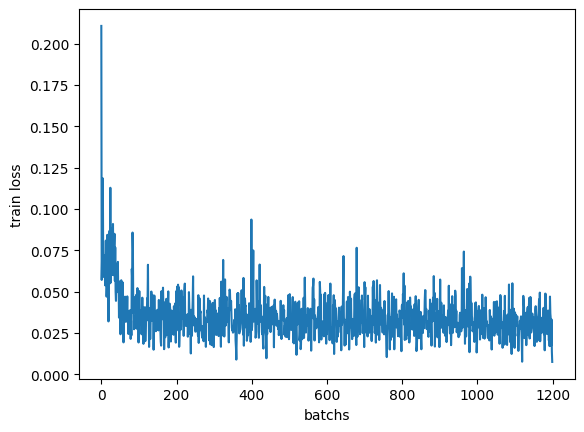

In [7]:
device = 'cuda:0'
classifier = classifier.to(device)
model = selection_function.to(device)
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
num_epochs = 30

log_loss = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    
    classifier.eval()
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_corrects = 0

    total_selective_loss = None
    # Iterate over data.
    for inputs, labels in dataloader_train:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # # FIRST WAY: SCALE LOSS WITH SELECTION (freeze all except last layer)
        # # classify inputs
        # with torch.no_grad():
        #     class_predictions = classifier(inputs)
        #     loss_without_selection = criterion(class_predictions, labels)
        # # forward
        # selected_data = torch.sigmoid(model(inputs)).squeeze()
        # selective_loss = (loss_without_selection * selected_data).mean() + torch.maximum(0.8 - selected_data.mean(), torch.tensor(0))**2

        # # SECOND WAY: SCALE TARGETS (EQUIVALENT TO FIRST WAY)
        # class_predictions = classifier(inputs)
        # selected_data = torch.sigmoid(model(inputs)).squeeze()
        # labels = torch.nn.functional.one_hot(labels, n_classes)
        # labels = labels * selected_data.unsqueeze(1).expand(-1, n_classes) # equivalent to scaling loss
        # selective_loss = criterion(class_predictions, labels).sum() + 32*torch.maximum(0.8 - selected_data.mean(), torch.tensor(0))**2
        

        with torch.no_grad():
            logits = classifier(inputs)
        
        if SELECTION_INPUTS == 'images':
            selection_in = inputs
        elif SELECTION_INPUTS == 'features':
            selection_in = inputs # same network but only trainable after features
        elif SELECTION_INPUTS == 'logits':
            selection_in = logits
        elif SELECTION_INPUTS == 'all':
            selection_in = (inputs, logits)
        
        if PREDICTION == 'well_classified':
            selective_loss = predict_well_classified(logits, labels, selection_in)
        elif PREDICTION == 'tcp':
            selective_loss = predict_tcp(logits, labels, selection_in)
        elif PREDICTION == 'loss':        
            selective_loss = predict_loss(logits, labels, selection_in)

                    
        # print(selected_data.mean())
        selective_loss.backward()
        optimizer.step()
        
        log_loss.append(selective_loss.detach().cpu().numpy())
        total_selective_loss = selective_loss if total_selective_loss is None else total_selective_loss + selective_loss
        
    print(f'Total loss: {total_selective_loss}')
    
    # _, _, total_classif_correct, total_selection_out = get_classif_selection_outputs(model, classifier, dataloader_train)
    # accuracy, risk, coverage = get_selective_risk_at_cut(0.5, total_classif_correct, total_selection_out)
    # print(f'Train_risk: {risk:.4f}, train_accuracy: {100*accuracy:.2f}%, train_coverage: {100*coverage:.2f}%')
    
    # _, _, total_classif_correct, total_selection_out = get_classif_selection_outputs(model, classifier, dataloader_val)
    # accuracy, risk, coverage = get_selective_risk_at_cut(0.5, total_classif_correct, total_selection_out)
    # print(f'Val_risk: {risk:.4f}, val_accuracy: {100*accuracy:.2f}%, val_coverage: {100*coverage:.2f}%')
    
    scheduler.step()
    
    
plt.figure()
plt.plot(log_loss)
plt.xlabel('batchs')
plt.ylabel('train loss')

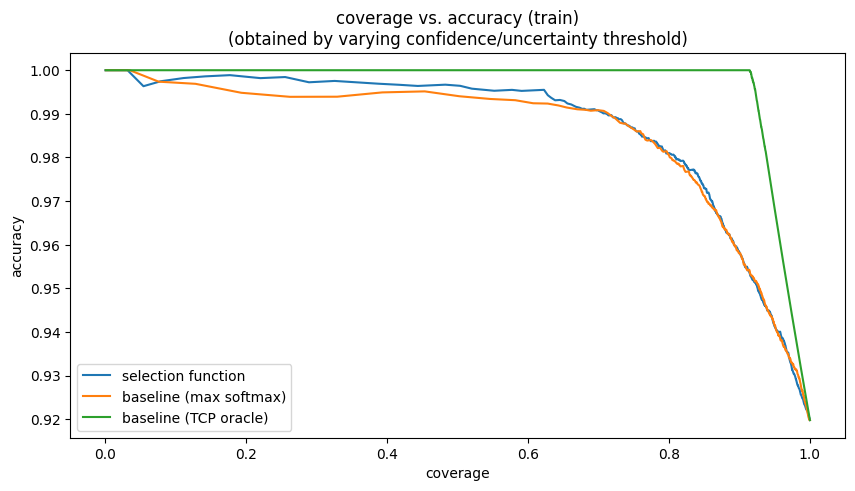

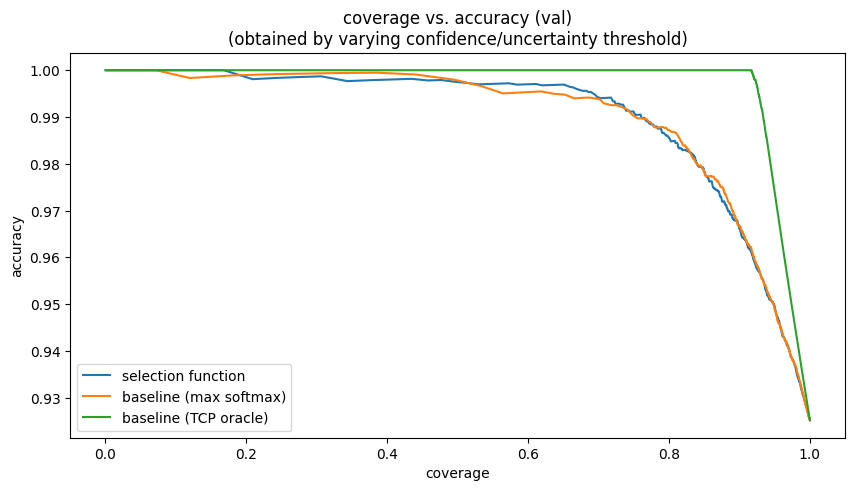

In [8]:
for dataloader, name in zip([dataloader_train, dataloader_val], ['train', 'val']):
    total_probas, total_tcp, total_classif_correct, total_selection_out = get_classif_selection_outputs(model, classifier, dataloader)

    # use selection function
    domain_cutoff = np.linspace(0, 1, 1000)
    coverage = np.zeros_like(domain_cutoff)
    risk = np.zeros_like(domain_cutoff)
    accuracy = np.zeros_like(domain_cutoff)
    for i, cut in enumerate(domain_cutoff):
        acc, _, cov = get_selective_risk_at_cut(cut, total_classif_correct, total_selection_out)
        coverage[i] = cov
        accuracy[i] = acc
        
    # baseline: random selection
    domain_cutoff_random = np.linspace(0, 1, 100)
    coverage_random = np.zeros_like(domain_cutoff_random)
    risk_random = np.zeros_like(domain_cutoff_random)
    acc_random = np.zeros_like(domain_cutoff_random)
    for i, cut in enumerate(domain_cutoff_random):
        nb_samples = int((1-cut) * len(total_probas)) # 1-cut to be coherent with other indices below (low value -> high coverage)
        idx_domain = rng.choice(np.arange(len(total_probas)), size=nb_samples, replace=False)
        coverage_random[i] = total_probas[idx_domain].shape[0] / len(total_probas)
        # risk_random[i] = total_classif_loss[idx_domain].mean()
        acc_random[i] = total_classif_correct[idx_domain].float().mean()
        
    # baseline: max softmax
    domain_cutoff_baseline = np.linspace(0, 1, 1000)
    coverage_baseline = np.zeros_like(domain_cutoff_baseline)
    risk_baseline = np.zeros_like(domain_cutoff_baseline)
    acc_baseline = np.zeros_like(domain_cutoff_baseline)
    for i, cut in enumerate(domain_cutoff_baseline):
        idx_domain = total_probas.max(dim=1).values > cut
        coverage_baseline[i] = idx_domain.float().mean()
        acc_baseline[i] = total_classif_correct[idx_domain].float().mean()

    # baseline: TCP (same results as thesholding on loss)
    domain_cutoff_baselineTCP = np.linspace(0, 1, 1000)
    coverage_baselineTCP = np.zeros_like(domain_cutoff_baselineTCP)
    risk_baselineTCP = np.zeros_like(domain_cutoff_baselineTCP)
    acc_baselineTCP = np.zeros_like(domain_cutoff_baselineTCP)
    for i, cut in enumerate(domain_cutoff_baselineTCP):
        idx_domain = total_tcp > cut
        coverage_baselineTCP[i] = idx_domain.float().mean()
        acc_baselineTCP[i] = total_classif_correct[idx_domain].float().mean()
        
    # baseline loss: select based on loss value. same as TCP

    # plot
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
    ax1.set_title(f'coverage vs. accuracy ({name})\n(obtained by varying confidence/uncertainty threshold)')
    ax1.plot(coverage, accuracy, label='selection function')
    ax1.plot(coverage_baseline, acc_baseline, label='baseline (max softmax)')
    # ax1.plot(coverage_random, acc_random, label='baseline (random)')
    ax1.plot(coverage_baselineTCP, acc_baselineTCP, label='baseline (TCP oracle)')

    ax1.legend()
    ax1.set_xlabel('coverage')
    ax1.set_ylabel('accuracy')

Text(0.5, 0, 'selection function output')

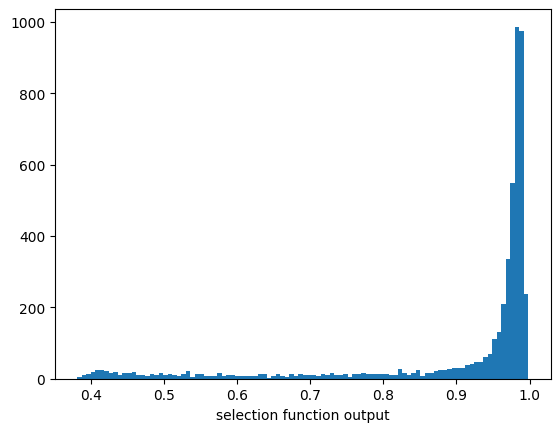

In [9]:
plt.figure()
plt.hist(total_selection_out.cpu().numpy(), bins=100);
plt.xlabel('selection function output')